In [1]:
# Libraries
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load and Filter
df = pd.read_csv('best_picture_complete.csv')
YEAR_COL = "year_ceremony"
df_filtered = df[df[YEAR_COL] <= 2020].copy() # since the ceremonies after 2020 are to be used to test our model

df_filtered['release_date'] = pd.to_datetime(df_filtered['release_date'])
df_filtered['quarter'] = df_filtered['release_date'].dt.quarter
df_filtered['runtime_int'] = df_filtered['Runtime'].astype(str).str.replace(' min', '').astype(int)

In [3]:
#### GENRE
# 3. Analyzing Genres
df_genres = df_filtered.assign(Genre=df_filtered['Genre'].str.split(', ')).explode('Genre')
genre_stats = df_genres.groupby(['Genre', 'winner']).size().unstack(fill_value=0)
genre_stats.columns = ['Nominees', 'Winners']
# Calculate win rate
genre_stats['Win_Rate'] = genre_stats['Winners'] / (genre_stats['Winners'] + genre_stats['Nominees'])
print("\n--- Top Genre Stats ---")
print(genre_stats.sort_values(by='Winners', ascending=False).head())


--- Top Genre Stats ---
           Nominees  Winners  Win_Rate
Genre                                 
Drama           150       29  0.162011
Biography        44        8  0.153846
Romance          36        7  0.162791
Thriller         21        7  0.250000
Crime            25        6  0.193548


In [4]:
#### RUNTIME ANALYSIS 

df_filtered['runtime_bin'] = pd.qcut(df_filtered['runtime_int'], q=5, labels=["Very Short", "Short", "Medium", "Long", "Very Long"])

runtime_stats = df_filtered.groupby(['runtime_bin', 'winner'], observed=False).size().unstack(fill_value=0)
runtime_stats_for_all = df_filtered.groupby('winner')['runtime_int'].agg(['mean', 'count', 'std'])
print("\n--- Runtime Stats ---")
print(runtime_stats_for_all)
print("\n")
print(runtime_stats)

# INDEPENDENT T-TEST FOR RUNTIME

runtimes_winners = df_filtered[df_filtered['winner'] == True]['runtime_int']
runtimes_nominees = df_filtered[df_filtered['winner'] == False]['runtime_int']

t_stat_run, p_val_run = stats.ttest_ind(runtimes_winners, runtimes_nominees, equal_var=False)

print(f"\n--- Runtime T-Test Results ---")
print(f"T-statistic: {t_stat_run:.4f}")
print(f"P-value:     {p_val_run:.4f}")

alpha = 0.05
if p_val_run < alpha:
    print("Result: Reject H0.")
    print("Interpretation: There is a significant difference in runtime between Winners and Nominees.")
else:
    print("Result: Fail to reject H0.")
    print("Interpretation: No significant difference in runtime found.")


# CHI-SQUARE TEST
runtime_contingency = pd.crosstab(df_filtered['runtime_bin'], df_filtered['winner'])

runtime_contingency.columns = ["Nominee (Lost)", "Winner"]

print("\n--- Observed Values (Quantile Bins) ---")
print(runtime_contingency)

chi2_run, p_run, dof_run, expected_run = stats.chi2_contingency(runtime_contingency)

print(f"\n--- Chi-Square Test for Runtime Quantiles ---")
print(f"Chi-Square Statistic: {chi2_run:.4f}")
print(f"P-value:              {p_run:.4f}")

# Interpretation
alpha = 0.05
print("\n--- ANALYSIS ---")
if p_run < alpha:
    print("Result: H0 is rejected.")
    print("Interpretation: There is a significant relationship between runtime intervals (quantiles) and winning an Oscar.")

    runtime_contingency['Win_Rate'] = runtime_contingency['Winner'] / (runtime_contingency['Winner'] + runtime_contingency['Nominee (Lost)'])

    best_bin = runtime_contingency['Win_Rate'].idxmax()
    highest_rate = runtime_contingency['Win_Rate'].max()

    print(f"Insight: The runtime interval with the highest win rate is {best_bin} (Win Rate: {highest_rate:.2%})")
    print("\nWin Rates per Quantile:")
    print(runtime_contingency['Win_Rate'].sort_values(ascending=False))
else:
    print("Result: We fail to reject H0.")
    print("Interpretation: There is no significant relationship between runtime intervals and winning an Oscar.")


--- Runtime Stats ---
              mean  count        std
winner                              
False   129.944785    163  22.740145
True    137.766667     30  27.197469


winner       False  True 
runtime_bin              
Very Short      37      3
Short           28     10
Medium          35      7
Long            33      2
Very Long       30      8

--- Runtime T-Test Results ---
T-statistic: 1.4827
P-value:     0.1467
Result: Fail to reject H0.
Interpretation: No significant difference in runtime found.

--- Observed Values (Quantile Bins) ---
             Nominee (Lost)  Winner
runtime_bin                        
Very Short               37       3
Short                    28      10
Medium                   35       7
Long                     33       2
Very Long                30       8

--- Chi-Square Test for Runtime Quantiles ---
Chi-Square Statistic: 8.8250
P-value:              0.0656

--- ANALYSIS ---
Result: We fail to reject H0.
Interpretation: There is no significant 

--- Quarter Stats ---
         Nominees  Winners
quarter                   
1.0             9        2
2.0            10        4
3.0            26        3
4.0           118       20
--- OBSERVED VALUES ---
              Nominee (Lost)  Won
Q1 (Jan-Mar)               9    2
Q2 (Apr-Jun)              10    4
Q3 (Jul-Sep)              26    3
Q4 (Oct-Dec)             118   20


Chi-Square Statistics: 2.6139
P-value:     0.4551
Degrees of Freedom:    3

--- ANALYSIS ---
Result: We fail to reject H0.
Interpretation: There is not a significant relationship between Oscar winning and relase date of the movie.


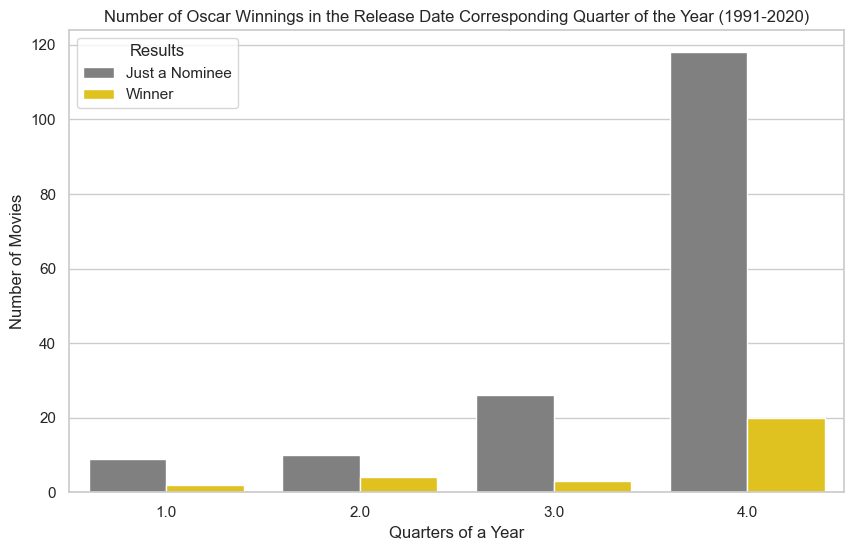

In [5]:
#### QUARTER / RELEASE DATE
# 2. Analyzing Quarters
quarter_stats = df_filtered.groupby(['quarter', 'winner']).size().unstack(fill_value=0)
quarter_stats.columns = ['Nominees', 'Winners']
print("--- Quarter Stats ---")
print(quarter_stats)

# CHI-SQUARE Test
contingency_table = pd.crosstab(df_filtered['quarter'], df_filtered['winner'])
contingency_table.index = ["Q1 (Jan-Mar)", "Q2 (Apr-Jun)", "Q3 (Jul-Sep)", "Q4 (Oct-Dec)"]
contingency_table.columns = ["Nominee (Lost)", "Won"]

print("--- OBSERVED VALUES ---")
print(contingency_table)
print("\n" + "="*40 + "\n")

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Results
print(f"Chi-Square Statistics: {chi2:.4f}")
print(f"P-value:     {p:.4f}")
print(f"Degrees of Freedom:    {dof}")

# Interpretation
alpha = 0.05
print("\n--- ANALYSIS ---")
if p < alpha:
    print("Result: H0 is rejected. ")
    print("Interpretation: There is a significant relationship between Oscar winning and relase date of the movie.")
else:
    print("Result: We fail to reject H0.")
    print("Interpretation: There is not a significant relationship between Oscar winning and relase date of the movie.")

# Visualization

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

plot_data = df_filtered.groupby('quarter')['winner'].value_counts(normalize=False).rename('count').reset_index()
plot_data['Data'] = plot_data['winner'].map({True: 'Winner', False: 'Just a Nominee'})

# Plotting
sns.barplot(
    data=plot_data,
    x='quarter',
    y='count',
    hue='Data',
    palette={'Winner': 'gold', 'Just a Nominee': 'grey'}
)  

plt.title('Number of Oscar Winnings in the Release Date Corresponding Quarter of the Year (1991-2020)')
plt.xlabel('Quarters of a Year')
plt.ylabel('Number of Movies')
plt.legend(title='Results')
plt.show()


--- General Meta Score Stats (Global) ---
             mean  count        std
winner                             
False   80.325153    163  11.404939
True    84.333333     30   9.367344


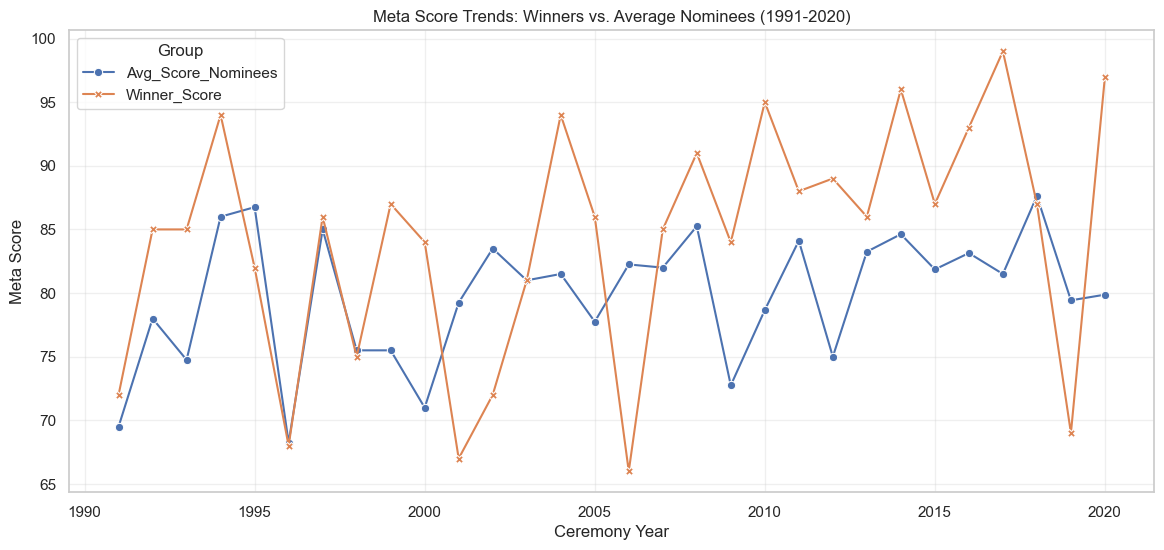


--- Paired T-Test Results (Meta Score) ---
T-statistic: 2.7615
P-value:     0.0099

--- ANALYSIS ---
Result: H0 is rejected (Significant).
Interpretation: There is a statistically significant difference.
Insight: Oscar Winners consistently have higher Meta Scores than their rivals.


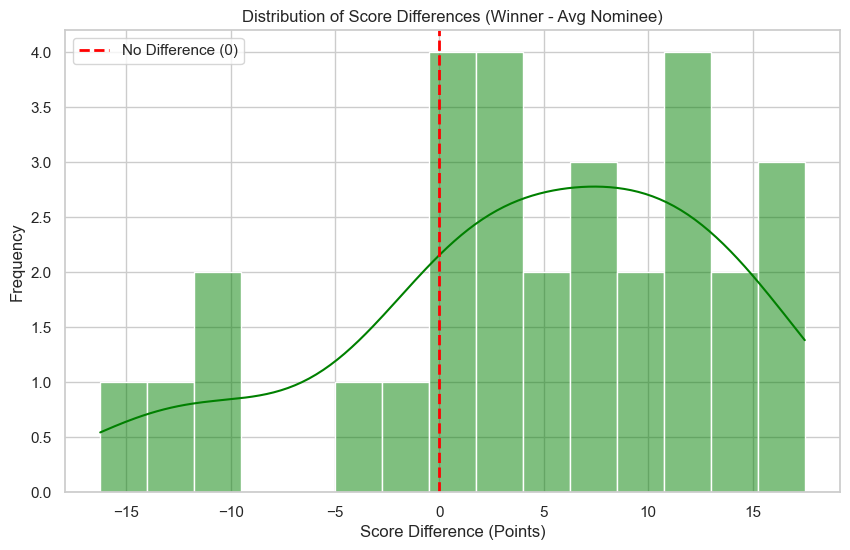


--- Does the 'Critical Favorite' Win? ---
Percentage of time the highest-rated movie wins: 33.33%


In [6]:
#### MetaScore

meta_stats = df_filtered.groupby('winner')['Meta_score'].agg(['mean', 'count', 'std'])
print("\n--- General Meta Score Stats (Global) ---")
print(meta_stats)


# --- YEARLY PAIRED ANALYSIS ---

yearly_meta = df_filtered.groupby(['year_ceremony', 'winner'])['Meta_score'].mean().unstack()
yearly_meta.columns = ['Avg_Score_Nominees', 'Winner_Score']

# 3. Visualization
plt.figure(figsize=(14, 6))
sns.lineplot(data=yearly_meta, markers=True, dashes=False)
plt.title('Meta Score Trends: Winners vs. Average Nominees (1991-2020)')
plt.ylabel('Meta Score')
plt.xlabel('Ceremony Year')
plt.legend(title='Group')
plt.grid(True, alpha=0.3)
plt.show()


# --- PAIRED T-TEST ---

paired_clean = yearly_meta.dropna()
t_stat_meta, p_val_meta = stats.ttest_rel(paired_clean['Winner_Score'], paired_clean['Avg_Score_Nominees'])

print(f"\n--- Paired T-Test Results (Meta Score) ---")
print(f"T-statistic: {t_stat_meta:.4f}")
print(f"P-value:     {p_val_meta:.4f}")

alpha = 0.05
print("\n--- ANALYSIS ---")
if p_val_meta < alpha:
    print("Result: H0 is rejected (Significant).")
    print("Interpretation: There is a statistically significant difference.")
    if t_stat_meta > 0:
        print("Insight: Oscar Winners consistently have higher Meta Scores than their rivals.")
    else:
        print("Insight: Oscar Winners actually have LOWER scores (Rare/Unexpected).")
else:
    print("Result: Fail to reject H0.")
    print("Interpretation: Critics' scores do not significantly differentiate winners from nominees.")


# --- VISUALIZING THE "CRITIC GAP" ---
paired_clean['Score_Diff'] = paired_clean['Winner_Score'] - paired_clean['Avg_Score_Nominees']

plt.figure(figsize=(10, 6))
sns.histplot(paired_clean['Score_Diff'], kde=True, color='green', bins=15)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No Difference (0)')

plt.title('Distribution of Score Differences (Winner - Avg Nominee)')
plt.xlabel('Score Difference (Points)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# --- "CRITICAL FAVORITE" ANALYSIS ---
print("\n--- Does the 'Critical Favorite' Win? ---")

max_scores_per_year = df_filtered.groupby('year_ceremony')['Meta_score'].transform('max')

winners = df_filtered[df_filtered['winner'] == True].copy()
winners['is_top_rated'] = winners['Meta_score'] == max_scores_per_year[winners.index]

top_rated_win_rate = winners['is_top_rated'].mean()
print(f"Percentage of time the highest-rated movie wins: {top_rated_win_rate:.2%}")


STATISTICAL ANALYSIS: Director Nomination vs Best Picture Win

--- Observed Values ---
                  Lost BP  Won BP
No Director Nom        66       2
Has Director Nom       97      28

--- Chi-Square Results ---
Chi-Square Statistic: 11.2638
P-value:              0.0007903

Result: SIGNIFICANT (p < 0.05)
Interpretation: There is a statistically significant relationship.
Movies nominated for Best Director are significantly more likely to win Best Picture.

Win Rate WITH Director Nom:    22.40%
Win Rate WITHOUT Director Nom: 2.94%


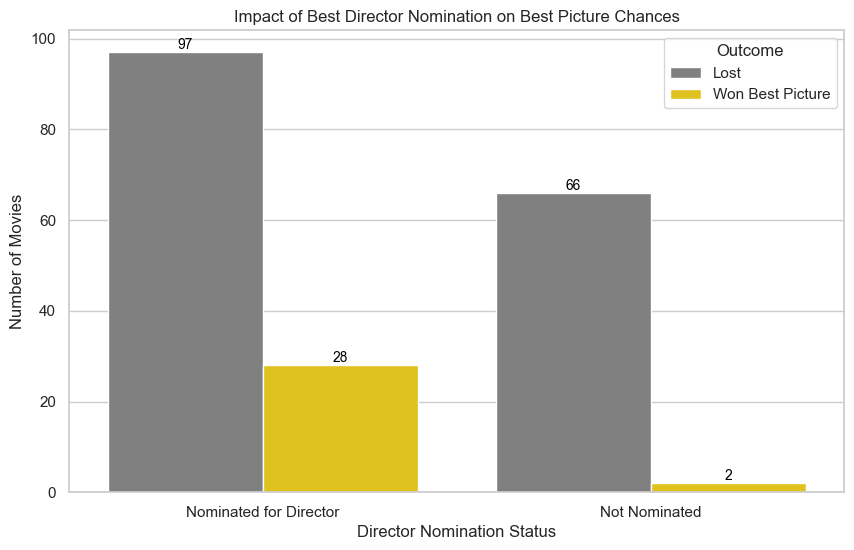

In [7]:
#### DUAL NOMINATION
print("\n" + "="*60)
print("STATISTICAL ANALYSIS: Director Nomination vs Best Picture Win")
print("="*60)

dir_nom_col = 'nominated_director_and_picture'

if dir_nom_col not in df_filtered.columns:
    print(f"\n[Error] Column '{dir_nom_col}' not found in the dataframe.")
    print("Please ensure you loaded the updated CSV file containing the director nomination flag.")
else:
    df_filtered[dir_nom_col] = df_filtered[dir_nom_col].astype(bool)

    contingency_dir = pd.crosstab(df_filtered[dir_nom_col], df_filtered['winner'])
    contingency_dir.index = ["No Director Nom", "Has Director Nom"]
    contingency_dir.columns = ["Lost BP", "Won BP"]

    print("\n--- Observed Values ---")
    print(contingency_dir)

    # Chi-Square Test
    chi2_d, p_d, dof_d, exp_d = stats.chi2_contingency(contingency_dir)
    print(f"\n--- Chi-Square Results ---")
    print(f"Chi-Square Statistic: {chi2_d:.4f}")
    print(f"P-value:              {p_d:.4g}")
    # Interpretation
    alpha = 0.05
    if p_d < alpha:
        print("\nResult: SIGNIFICANT (p < 0.05)")
        print("Interpretation: There is a statistically significant relationship.")
        print("Movies nominated for Best Director are significantly more likely to win Best Picture.")
        
        if "Has Director Nom" in contingency_dir.index:
            wins = contingency_dir.loc["Has Director Nom", "Won BP"]
            total = contingency_dir.loc["Has Director Nom"].sum()
            win_rate_with_nom = wins / total if total > 0 else 0
            print(f"\nWin Rate WITH Director Nom:    {win_rate_with_nom:.2%}")
        
        if "No Director Nom" in contingency_dir.index:
            wins = contingency_dir.loc["No Director Nom", "Won BP"]
            total = contingency_dir.loc["No Director Nom"].sum()
            win_rate_no_nom = wins / total if total > 0 else 0
            print(f"Win Rate WITHOUT Director Nom: {win_rate_no_nom:.2%}")
    else:
        print("\nResult: Fail to reject H0.")
        print("Interpretation: No significant relationship found.")
    # Visualization
    plt.figure(figsize=(10, 6))
    
    plot_df = df_filtered.copy()
    plot_df['Director_Nom_Status'] = plot_df[dir_nom_col].map({True: 'Nominated for Director', False: 'Not Nominated'})
    plot_df['Outcome'] = plot_df['winner'].map({True: 'Won Best Picture', False: 'Lost'})
    
    ax = sns.countplot(
        data=plot_df, 
        x='Director_Nom_Status', 
        hue='Outcome', 
        palette={'Won Best Picture': 'gold', 'Lost': 'grey'},
        hue_order=['Lost', 'Won Best Picture']
    )
    
    plt.title('Impact of Best Director Nomination on Best Picture Chances')
    plt.xlabel('Director Nomination Status')
    plt.ylabel('Number of Movies')
    plt.legend(title='Outcome')
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
             ax.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black')
    
    plt.show()